In [40]:
#GENERAL CONFIG

LABELS_FONTSIZE = 18
TICKS_FONTSIZE = 16
TITLE_FONTSIZE = 18
LEGEND_FONTSIZE = 16

FRAME_TYPE = 'all' #all, i or p


ANCHOR_PATH = "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/anchor.json"

TESTS_PATHS = [
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/polinomial.json",    
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/lut_asyn.json",    
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/lut_sym.json",    
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/poly_16.json",   
]

TESTS_LABELS = [
    "polinomial",
    "lut_asyn",
    "lut_sym",
    "poly_16"
]

DATASET = "HEVC_B"

In [41]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from bjontegaard import bd_rate, bd_psnr


def extract_by_sequence(data, frame_type):
    results = defaultdict(lambda: defaultdict(dict))
    for dataset, sequences in data.items():
        for seq, entries in sequences.items():
            for key, v in entries.items():
                rate_idx = v["rate_idx"]
                bpp = v[f"ave_{frame_type}_frame_bpp"]
                psnr = v[f"ave_{frame_type}_frame_psnr"]
                results[dataset][seq][rate_idx] = (bpp, psnr)
    return results

In [42]:
# -*- coding: utf-8 -*-, 32
# Lê o JSON no formato mostrado e transforma em um DataFrame "tidy".
# Funciona tanto recebendo um caminho de arquivo quanto uma string JSON.

from pathlib import Path
import json
import pandas as pd

def metrics_json_to_df(src):
    """
    src: caminho para arquivo .json OU string JSON.
    retorna: pandas.DataFrame com colunas planas (dataset, sequence, rate_idx, ...).
    """
    # 1) Carregar o JSON
    if isinstance(src, (str, Path)) and Path(str(src)).exists():
        with open(src, "r", encoding="utf-8") as f:
            data = json.load(f)
    elif isinstance(src, (str, bytes)) and str(src).lstrip().startswith("{"):
        data = json.loads(src)
    else:
        raise ValueError("Passe um caminho existente para o arquivo .json ou uma string JSON válida.")

    # 2) Percorrer a estrutura e coletar linhas
    rows = []
    for dataset_name, sequences in data.items():                 # ex.: "UVG", "HEVC_B", ...
        for seq_name, rates in sequences.items():                # ex.: "Beauty_1920x1080_120", ...
            for rate_key, metrics in rates.items():              # ex.: "000", "001", ...
                # Copiar o dict de métricas e adicionar chaves de contexto
                m = dict(metrics)  # copia
                m["dataset"]  = dataset_name
                m["sequence"] = seq_name

                # rate_idx já vem no JSON como inteiro; o rate_key é string ("000", ...).
                # Mantemos o 'rate_idx' como coluna principal (int) e também guardamos o rótulo textual, se útil.
                m["rate_key"] = rate_key
                # opcional: garantir consistência (não é obrigatório)
                if "rate_idx" not in m:
                    # se não existir, derivar do rótulo textual
                    try:
                        m["rate_idx"] = int(rate_key)
                    except Exception:
                        pass

                # Evitar duplicatas redundantes (o JSON já inclui ds_name/seq internos)
                m.pop("ds_name", None)
                m.pop("seq", None)

                rows.append(m)

    # 3) Criar DataFrame
    df = pd.DataFrame.from_records(rows)

    # 4) Tipos e ordenação (opcional)
    if "rate_idx" in df.columns:
        df["rate_idx"] = pd.to_numeric(df["rate_idx"])
        df = df.sort_values(["dataset", "sequence", "rate_idx"]).reset_index(drop=True)
    else:
        df = df.sort_values(["dataset", "sequence", "rate_key"]).reset_index(drop=True)

    return df




In [43]:
df_results = metrics_json_to_df(ANCHOR_PATH)
df_results["experiment"] = "anchor"

for test in TESTS_PATHS:
    test_df = metrics_json_to_df(test)
    test_df["experiment"] = test.split("/")[-1].replace(".json", "")
    df_results = pd.concat([df_results, test_df], ignore_index=True)

# df_results.columns

In [44]:
# 1) Lista de experiments únicos
df = df_results

experiments = df['experiment'].dropna().unique()
print("Experiments únicos:", experiments)

# 2) Para cada experiment, lista datasets únicos
#    (ignorando NaN em 'dataset')
exp_to_datasets = (
    df.dropna(subset=['experiment', 'dataset'])
      .groupby('experiment')['dataset']
      .unique()
      .sort_index()
)

print("\nDatasets por experiment:")
for exp, dsets in exp_to_datasets.items():
    print(f"  {exp}: {sorted(map(str, dsets))}")

# 3) Datasets que aparecem em TODOS os experiments
#    (forma 1: interseção de conjuntos)
if len(exp_to_datasets) == 0:
    common_datasets = set()
else:
    common_datasets = set(exp_to_datasets.iloc[0])
    for dsets in exp_to_datasets.iloc[1:]:
        common_datasets &= set(dsets)

print("\nDatasets presentes em TODOS os experiments:", sorted(map(str, common_datasets)))

# (alternativa equivalente, concisa)
# total_exps = df['experiment'].dropna().nunique()
# counts = (df.dropna(subset=['experiment','dataset'])
#             .groupby('dataset')['experiment'].nunique())
# common_datasets_alt = set(counts[counts == total_exps].index)

# Filtrar o df
df_filtered = df[df['dataset'].isin(common_datasets)].copy()

# (Opcional) ver o que foi removido
all_datasets = set(df['dataset'].dropna().unique())
removed = sorted(map(str, all_datasets - common_datasets))
print("\nDatasets removidos:", removed)

# Resultado final:
# df_filtered contém apenas linhas cujos 'dataset' aparecem em todos os 'experiment'
df_results = df_filtered

Experiments únicos: ['anchor' 'polinomial' 'lut_asyn' 'lut_sym' 'poly_16']

Datasets por experiment:
  anchor: ['HEVC_B']
  lut_asyn: ['HEVC_B']
  lut_sym: ['HEVC_B']
  polinomial: ['HEVC_B']
  poly_16: ['HEVC_B']

Datasets presentes em TODOS os experiments: ['HEVC_B']

Datasets removidos: []


In [45]:
import pandas as pd
import numpy as np

def averages_by_rate(df, experiment=None, dataset=None, frame_type='all'):
    """
    Filters the DataFrame and returns three NumPy arrays:
      - rate_vals : rate values (sorted)
      - bpp_means    : average bpp for each quality
      - psnr_means   : average psnr for each quality

    Any parameter can be set to None to skip filtering by that field.
    """
    cond = pd.Series(True, index=df.index)

    
    
    if dataset is not None:
        cond &= (df['dataset'] == dataset)
    cond &= (df['experiment'] == experiment)

    df_filtered = df[cond]

    if df_filtered.empty:
        raise ValueError("No data found with these parameters.")

    df_group = df_filtered.groupby('rate_idx').agg(
        bpp_mean=(f"ave_{frame_type}_frame_bpp", 'mean'),
        psnr_mean=(f"ave_{frame_type}_frame_psnr", 'mean')
        
    ).reset_index().sort_values('rate_idx')

    rate_vals = df_group['rate_idx'].to_numpy()
    bpp_means = df_group['bpp_mean'].to_numpy()
    psnr_means = df_group['psnr_mean'].to_numpy()

    return rate_vals, bpp_means, psnr_means

/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:54: UserWarning: Insufficient curve overlap: '73.45'. Minimum overlap: '75.00'. You can silence this warning by setting `min_overlap=0`
  warnings.warn(
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:54: UserWarning: Insufficient curve overlap: '50.88'. Minimum overlap: '75.00'. You can silence this warning by setting `min_overlap=0`
  warnings.warn(
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:49: UserWarning: Curves do not overlap. BD cannot be calculated.
  warnings.warn("Curves do not overlap. BD cannot be calculated.")


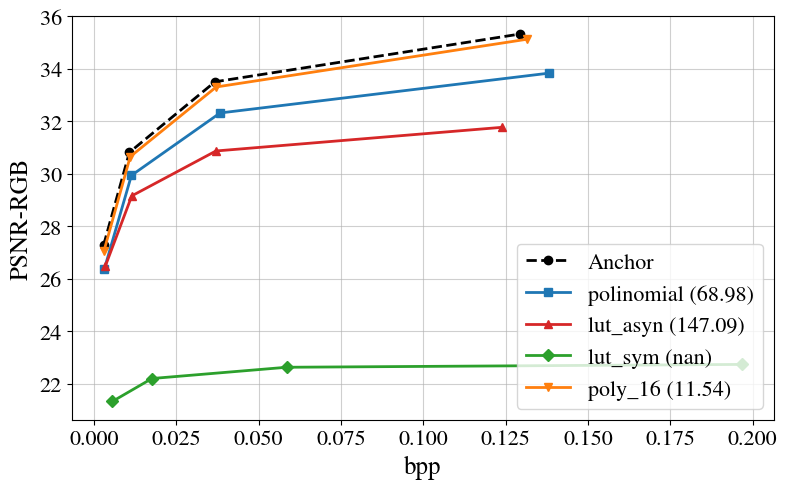

In [46]:
# colors = ['black', 'blue', 'orange', 'green', 'red', 'pink',]
colors = [
    "#000000",  # Preto -> linha de base / anchor
    "#1f77b4",  # Azul forte
    "#d62728",  # Vermelho científico
    "#2ca02c",  # Verde bem definido
    "#ff7f0e",  # Laranja destacado
    "#9467bd",  # Roxo sóbrio
    "#8c564b",  # Marrom científico
    "#e377c2",  # Rosa/magenta claro
    "#7f7f7f",  # Cinza neutro
    "#bcbd22"   # Amarelo mostarda
]

markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(8, 5))
plt.rcParams["font.family"] = "Nimbus Roman"


_, bpp_anchor, psnr_anchor = averages_by_rate(df_results, experiment="anchor", dataset=DATASET, frame_type=FRAME_TYPE)
plt.plot(
    bpp_anchor, psnr_anchor,
    label=f'Anchor',    
    linewidth=2,
    marker=markers[0],
    color=colors[0], linestyle='--',  # linha tracejada para o anchor
)


for i, exp in enumerate(TESTS_LABELS):
    _, bpp, psnr = averages_by_rate(
        df_results,
        experiment=f"{exp}",
        frame_type=FRAME_TYPE,                        
        dataset=DATASET
    )

    try:
        bdbd = bd_rate(bpp_anchor, psnr_anchor, bpp, psnr, 'akima')
    except:
        bdbd = float("NaN")

    plt.plot(
        bpp, psnr,
        label=f'{exp} ({bdbd:.2f})',
        linewidth=2,
        marker=markers[(i+1)%len(markers)],
        color=colors[(i+1)%len(colors)],         
    )

plt.xlabel('bpp', fontsize=LABELS_FONTSIZE)
plt.ylabel('PSNR-RGB', fontsize=LABELS_FONTSIZE)
plt.legend(fontsize=LEGEND_FONTSIZE, loc="lower right")   # aumenta a legenda
plt.tick_params(axis='both', labelsize=TICKS_FONTSIZE)  # aumenta os ticks dos eixos
plt.grid(True, linestyle='-', alpha=0.6)
# plt.xticks(np.arange(0, 0.4, 0.1))
# plt.yticks(np.arange(22, 37, 5))
# plt.xlim(0, 0.1)    # eixo X vai de 0 a 1.0
# plt.ylim(29, 36)    # eixo Y vai de 20 a 50
plt.tight_layout()   

# plt.savefig("/data/Ruhan/TCSVT2025/uniform_analysis.pdf", dpi=1200, bbox_inches="tight")   # formato PNG


NameError: name 'PRECISIONS' is not defined

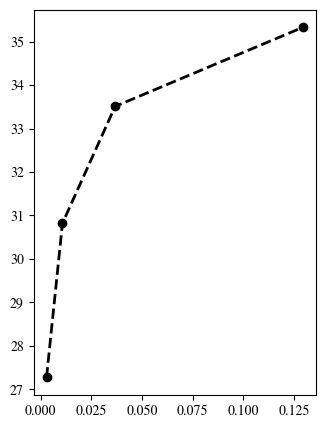

In [47]:
# colors = ['black', 'blue', 'orange', 'green', 'red', 'pink',]
colors = [
    "#000000",  # Preto -> linha de base / anchor
    "#1f77b4",  # Azul forte
    "#d62728",  # Vermelho científico
    "#2ca02c",  # Verde bem definido
    "#ff7f0e",  # Laranja destacado
    "#9467bd",  # Roxo sóbrio
    "#8c564b",  # Marrom científico
    "#e377c2",  # Rosa/magenta claro
    "#7f7f7f",  # Cinza neutro
    "#bcbd22"   # Amarelo mostarda
]

markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(8, 5))
plt.rcParams["font.family"] = "Nimbus Roman"


plt.subplot(1,2,1)


_, bpp_anchor, psnr_anchor = averages_by_rate(df_results, experiment="anchor", dataset=DATASET, frame_type='all')
plt.plot(
    bpp_anchor, psnr_anchor,
    label=f'Anchor',    
    linewidth=2,
    marker=markers[0],
    color=colors[0], linestyle='--',  # linha tracejada para o anchor

)

for i, bw in enumerate(PRECISIONS[1:]):
# for i, bw in enumerate([16, 32]):
    _, bpp, psnr = averages_by_rate(
        df_results,
        experiment=f"all_w{bw}_a{bw}",
        frame_type=FRAME_TYPE,                        
        dataset=DATASET
    )

    try:
        bdbd = bd_rate(bpp_anchor, psnr_anchor, bpp, psnr, 'akima')
    except:
        bdbd = float("NaN")

    plt.plot(
        bpp, psnr,
        label=f'W{bw}A{bw}',
        linewidth=2,
        marker=markers[(i+2)%len(markers)],
        color=colors[(i+2)%len(colors)],         
    )



plt.title("Low-quality range", fontsize=TITLE_FONTSIZE)
plt.xlabel('bpp', fontsize=LABELS_FONTSIZE)
plt.ylabel('PSNR-RGB', fontsize=LABELS_FONTSIZE)
plt.legend(fontsize=LEGEND_FONTSIZE, loc="lower right")   # aumenta a legenda
plt.tick_params(axis='both', labelsize=TICKS_FONTSIZE)  # aumenta os ticks dos eixos
plt.xticks(np.arange(0, 1, 0.02))
plt.yticks(np.arange(26, 32, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 0.02)    # eixo X vai de 0 a 1.0
plt.ylim(26, 31)    # eixo Y vai de 20 a 50
plt.tight_layout()   




plt.subplot(1,2,2)


_, bpp_anchor, psnr_anchor = averages_by_rate(df_results, experiment="anchor", dataset=DATASET, frame_type='all')
plt.plot(
    bpp_anchor, psnr_anchor,
    label=f'Anchor',    
    linewidth=2,
    marker=markers[0],
    color=colors[0], linestyle='--',  # linha tracejada para o anchor

)

prec_iterate = PRECISIONS[1:]
for i, bw in enumerate(prec_iterate):
# for i, bw in enumerate([16, 32]):
    _, bpp, psnr = averages_by_rate(
        df_results,
        experiment=f"all_w{bw}_a{bw}",
        frame_type=FRAME_TYPE,                        
        dataset=DATASET
    )   

    try:
        bdbd = bd_rate(bpp_anchor, psnr_anchor, bpp, psnr, 'akima')
    except:        
        bdbd = float("NaN")

    plt.plot(
        bpp, psnr,
        label=f'W{bw}A{bw}',
        linewidth=2,
        marker=markers[(i+2)%len(markers)],
        color=colors[(i+2)%len(colors)],         
    )



plt.title("High-quality range", fontsize=TITLE_FONTSIZE)
plt.xlabel('bpp', fontsize=LABELS_FONTSIZE)
# plt.ylabel('PSNR-RGB', fontsize=LABELS_FONTSIZE)
plt.legend(fontsize=LEGEND_FONTSIZE, loc="lower right")   # aumenta a legenda
plt.tick_params(axis='both', labelsize=TICKS_FONTSIZE)  # aumenta os ticks dos eixos
plt.xticks(np.arange(0, 1, 0.02))
plt.yticks(np.arange(33, 37, 1))

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0.05, 0.165)    # eixo X vai de 0 a 1.0
plt.ylim(33, 36)    # eixo Y vai de 20 a 50
plt.tight_layout()  


# plt.savefig("/data/Ruhan/TCSVT2025/uniform_analysis_lq_hq.pdf", dpi=1200, bbox_inches="tight")   # formato PNG


In [ ]:
import matplotlib.font_manager as fm

print(sorted(set(f.name for f in fm.fontManager.ttflist)))


['C059', 'D050000L', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Droid Sans Fallback', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Serif', 'MathJax_AMS', 'MathJax_Caligraphic', 'MathJax_Fraktur', 'MathJax_Main', 'MathJax_Math', 'MathJax_SansSerif', 'MathJax_Script', 'MathJax_Size1', 'MathJax_Size2', 'MathJax_Size3', 'MathJax_Size4', 'MathJax_Typewriter', 'MathJax_Vector', 'MathJax_Vector-Bold', 'MathJax_WinChrome', 'MathJax_WinIE6', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans Narrow', 'Noto Kufi Arabic', 'Noto Looped Lao', 'Noto Looped Lao UI', 'Noto Looped Thai', 'Noto Looped Thai UI', 'Noto Mono', 'Noto Music', 'Noto Naskh Arabic', 'Noto Naskh Arabic UI', 'Noto Nastaliq Urdu', 'Noto Rashi Hebrew', 'Noto Sans', 'Noto Sans Adlam', 'Noto Sans Adlam Unjoined', 'Noto Sans Anatolian Hieroglyphs', 'Noto Sans Arabic', 'Noto Sans Arabic UI', 'Noto Sans Armenian', 'Noto Sans Avestan', 'Noto